In [1]:
import torch
import numpy as np
from PIL import Image
from face_box import face_box
from model.recon import ModelArgs , face_model , process_uv , bilinear_interpolate_numpy ,get_colors_from_uv
from util.io import visualize
from util.preprocess import get_data_path
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

# Helper function to load an image and convert it to a tensor using the facebox detector
def load_image_as_tensor(image_path, facebox_detector, device):
    """Loads an image and processes it with the face detector, returning the tensor for 3D reconstruction."""
    im = Image.open(image_path).convert('RGB')
    trans_params, im_tensor = facebox_detector(im)
    return im_tensor.to(device), trans_params, im

# Helper function to perform 3D reconstruction
def reconstruct_3d_face(image_tensor, recon_model):
    """Runs the 3D reconstruction model on the input image tensor."""
    recon_model.input_img = image_tensor
    results = recon_model.forward()
    return results

# Helper function to visualize or extract 3D data in memory
def visualize_3d_in_memory(results, trans_params, image_pil):
    """Visualizes the 3D face reconstruction in memory (e.g., by returning key 3D data)."""
    # Using the visualize method to process the results without saving to disk
    my_visualize = visualize(results, None)  # No need to save path
    # Return important details like landmarks or vertices
    vertices = my_visualize.get_vertices()
    return vertices


c:\Users\Omar\.conda\envs\TDDFAV3\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def process_images_and_reconstruct_3d(source_image_path, target_image_path, facebox_detector, device, recon_model):
    # Read and convert target image
    target_image = cv2.imread(target_image_path)
    target_image_rgb = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)

    # Read and convert source image
    source_image = cv2.imread(source_image_path)
    source_image_rgb = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)

    # Load source and target images as tensors
    source_image_tensor, source_trans_params, source_pil = load_image_as_tensor(source_image_path, facebox_detector, device)
    target_image_tensor, target_trans_params, target_pil = load_image_as_tensor(target_image_path, facebox_detector, device)

    # Reconstruct 3D faces for both source and target
    source_3d_results, source_alpha_dict = reconstruct_3d_face(source_image_tensor, recon_model)
    target_3d_results, target_alpha_dict = reconstruct_3d_face(target_image_tensor, recon_model)

    # Extract necessary parameters
    source_expression_param = source_alpha_dict['exp']
    source_facial_lm = source_3d_results['ldm68'][0]  # batch size of 1
    target_id_param = target_alpha_dict['id']
    target_facial_lm = target_3d_results['ldm68'][0]
    uv_coords_target = target_3d_results['uv_coords']  # UV coordinates from target face
    target_texture_target = target_3d_results['extractTex']  # Extracted texture from target face
    target_face_mask = target_3d_results["render_mask"][0].astype(np.uint8)
    target_face_mask = cv2.resize(target_face_mask, (target_image.shape[1], target_image.shape[0]))

    # Return all processed data
    return {
        'source_image_rgb': source_image_rgb,
        'target_image_rgb': target_image_rgb,
        'source_expression_param': source_expression_param,
        "target_alpha_dict" : target_alpha_dict,
        'source_facial_lm': source_facial_lm,
        'target_id_param': target_id_param,
        'target_facial_lm': target_facial_lm,
        'uv_coords_target': uv_coords_target,
        'target_texture_target': target_texture_target,
        'target_face_mask': target_face_mask
    }




In [3]:
def transfer_expression_and_render_face(source_image_rgb, target_image_rgb, recon_model, 
                                        target_id_param, source_expression_param, 
                                        target_alpha_dict, plot=False):
    # Step 1: Generate the new 3D shape for the target with the source's expression
    target_new_shape = recon_model.compute_shape(target_id_param, source_expression_param)

    # Step 2: Apply the target's rotation (pose) to the new shape
    rotation = recon_model.compute_rotation(target_alpha_dict['angle'])  # Use the target's rotation

    # Step 3: Apply the target's translation to the transformed shape
    translated_shape = recon_model.transform(target_new_shape, rotation, target_alpha_dict['trans'])  # Use the target's translation

    # Step 4: Convert the transformed 3D shape to camera coordinates
    v3d = recon_model.to_camera(translated_shape)

    # Step 5: Project the 3D vertices onto the 2D image plane
    v2d = recon_model.to_image(v3d)

    # Step 6: Generate texture using the target's albedo and lighting
    face_albedo = recon_model.compute_albedo(target_alpha_dict['alb'])  # Albedo from the target
    face_norm = recon_model.compute_norm(target_new_shape)              # Normals based on the new 3D shape
    face_norm_roted = face_norm @ rotation                              # Apply rotation to normals
    face_texture = recon_model.compute_texture(face_albedo, face_norm_roted, target_alpha_dict['sh'])  # Lighting and texture

    # Step 7: Render the face with the computed texture
    _, _, rendered_face, _ = recon_model.renderer(v3d.clone(), recon_model.tri, torch.clamp(face_texture, 0, 1).clone())

    # Step 8: Convert the rendered face to an image for further post-processing
    rendered_face_image = rendered_face.detach().cpu().permute(0, 2, 3, 1).numpy()[0]

    # Step 9: Convert rendered face to RGB
    rendered_face_rgb = (rendered_face_image * 255).astype(np.uint8)

    # Step 10: Optionally plot source image, target image, and rendered face side by side
    if plot:
        plt.figure(figsize=(15, 5))

        # Plot the source image
        plt.subplot(1, 3, 1)
        plt.imshow(source_image_rgb)
        plt.title('Source Image')
        plt.axis('off')

        # Plot the target image
        plt.subplot(1, 3, 2)
        plt.imshow(target_image_rgb)
        plt.title('Target Image')
        plt.axis('off')

        # Plot the rendered face
        plt.subplot(1, 3, 3)
        plt.imshow(rendered_face_rgb)
        plt.title('Rendered Face with Source Expression')
        plt.axis('off')

        # Display the plot
        plt.show()

    # Return the rendered face in RGB
    return rendered_face_rgb





In [4]:
# Instantiate the ModelArgs class with your desired arguments, including iscrop and detector
args = ModelArgs(
    device='cuda',          # Use 'cuda' for GPU
    extractTex=True,       # Disable texture extraction
    ldm68=True,             # Use 68 facial landmarks
    ldm106=False,           # Disable 106 facial landmarks
    ldm106_2d=False,        # Disable 2D projections of 106 facial landmarks
    ldm134=False,           # Disable 134 facial landmarks
    seg_visible=True,       # Enable visible part segmentation
    seg=True,               # Enable segmentation of eight facial parts
    backbone='resnet50',    # Specify the backbone for the reconstruction model
    iscrop=True,            # Enable cropping of input images
    detector='retinaface'   # Use 'retinaface' for face detection (or 'mtcnn' if preferred)
)

# Initialize the face detection and reconstruction models
recon_model = face_model(args)  # Reconstruction model
facebox_detector = face_box(args).detector  # Face detection model

device = args.device

use retinaface for face box


create cuda ctx on device cuda:0
create cuda ctx on device cuda:0


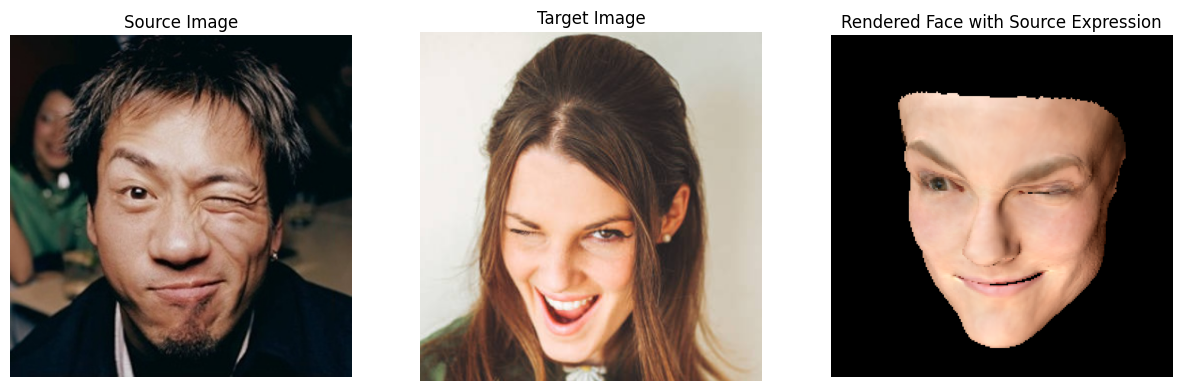

In [5]:
source_image_path = r"D:\3DDFA-V3\examples\1.jpg"

target_image_path = r"D:\3DDFA-V3\examples\2.png"

result = process_images_and_reconstruct_3d(
    source_image_path, 
    target_image_path, 
    facebox_detector, 
    device, 
    recon_model
)

# Extract necessary parameters
source_expression_param = result['source_expression_param']
source_facial_lm = result['source_facial_lm']
target_id_param = result['target_id_param']
target_alpha_dict = result['target_alpha_dict']
target_facial_lm = result['target_facial_lm']
uv_coords_target = result['uv_coords_target']
target_texture_target = result['target_texture_target']
target_face_mask = result['target_face_mask']

source_image_rgb = result["source_image_rgb"]
target_image_rgb = result["target_image_rgb"]

rendered_face_rgb = transfer_expression_and_render_face(
    source_image_rgb, 
    target_image_rgb, 
    recon_model, 
    target_id_param, 
    source_expression_param, 
    target_alpha_dict, 
    plot=True  # Set to False if you don't want to plot
)


##########

# Align The reconstructed face with the original face using land marks

In [6]:
def create_binary_mask(rendered_face_bgr):
    # Create a binary mask where face pixels are 1 and background is 0
    gray_image = cv2.cvtColor(rendered_face_bgr, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    return binary_mask

# Resize the rendered face and the binary mask to match the target image size
def resize_to_target(rendered_face_bgr, binary_mask, target_image):
    resized_face = cv2.resize(rendered_face_bgr, (target_image.shape[1], target_image.shape[0]))
    resized_mask = cv2.resize(binary_mask, (target_image.shape[1], target_image.shape[0]), interpolation=cv2.INTER_NEAREST)
    return resized_face, resized_mask



# Function to align source image (PIL) to target image (PIL) using facial landmarks
def align_images(source_image_pil, target_image_pil, source_landmarks, target_landmarks):
    # Convert PIL images to NumPy arrays (OpenCV format)
    source_image = np.array(source_image_pil)
    target_image = np.array(target_image_pil)
    
    # Ensure the images are in BGR format for OpenCV functions
    if source_image.shape[2] == 3:
        source_image = cv2.cvtColor(source_image, cv2.COLOR_RGB2BGR)
    if target_image.shape[2] == 3:
        target_image = cv2.cvtColor(target_image, cv2.COLOR_RGB2BGR)

    # Compute the affine transform matrix
    transformation_matrix, _ = cv2.estimateAffinePartial2D(source_landmarks, target_landmarks)
    
    # Warp the source image using the affine transformation
    aligned_source_image = cv2.warpAffine(source_image, transformation_matrix, (target_image.shape[1], target_image.shape[0]))

    # Convert the aligned image back to RGB and PIL format
    aligned_source_image = cv2.cvtColor(aligned_source_image, cv2.COLOR_BGR2RGB)
    aligned_source_image_pil = Image.fromarray(aligned_source_image)
    
    return aligned_source_image_pil


# Generate the binary mask
binary_mask_rendered_face = create_binary_mask(rendered_face_rgb)

rendered_face_resized_array , resized_mask = resize_to_target(rendered_face_rgb, binary_mask_rendered_face, target_image_rgb)

rendered_face_image = Image.fromarray(rendered_face_resized_array)

trans_params, im_tensor = facebox_detector(rendered_face_image)
rendered_face_tensor = im_tensor.to(device)
rendered_face_results, rendered_face_alpha_dict = reconstruct_3d_face(rendered_face_tensor, recon_model)

rendered_facial_lm = rendered_face_results["ldm68"]

# Align the rendered face with the target image
aligned_face = align_images(rendered_face_image, target_image_rgb, rendered_facial_lm, target_facial_lm)


binary_mask_aligned_face = create_binary_mask(np.array(aligned_face))





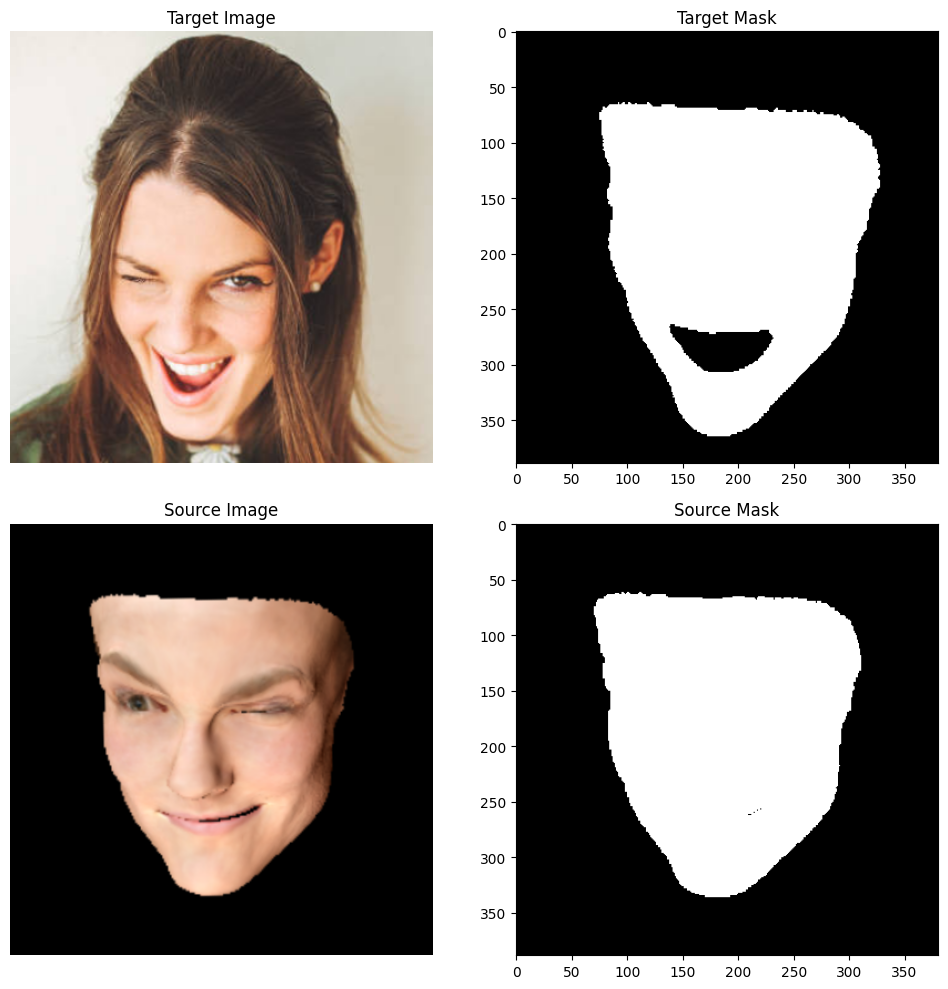

In [7]:
# Convert PIL images to NumPy arrays
target_image_np = np.array(target_image_rgb)
target_mask_np = np.array(target_face_mask)
source_image_np = np.array(aligned_face)
source_mask_np = np.array(binary_mask_aligned_face)

# Plotting the target image with its mask
plt.figure(figsize=(10, 10))

# Plot target image and mask side by side
plt.subplot(2, 2, 1)
plt.imshow(target_image_np)
plt.title("Target Image")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(target_mask_np, cmap='gray')
plt.title("Target Mask")

# Plot source image and mask side by side
plt.subplot(2, 2, 3)
plt.imshow(source_image_np)
plt.title("Source Image")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(source_mask_np, cmap='gray')
plt.title("Source Mask")

# Display the figures
plt.tight_layout()
plt.show()

# Blending the aligned face with the target image

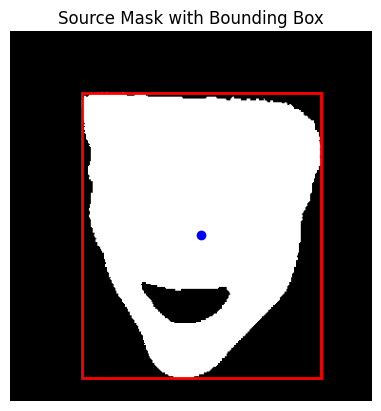

In [8]:
def get_bounding_box_center_and_plot(mask, image_title="Mask with Bounding Box"):
    # Find the coordinates of the non-zero pixels in the mask
    y_coords, x_coords = np.nonzero(mask)
    
    # Get the top-left and bottom-right corners of the bounding box
    top_left = (np.min(x_coords), np.min(y_coords))
    bottom_right = (np.max(x_coords), np.max(y_coords))
    
    # Calculate the center of the bounding box
    center_x = (top_left[0] + bottom_right[0]) // 2
    center_y = (top_left[1] + bottom_right[1]) // 2
    
    # Plot the mask with the bounding box
    plt.imshow(mask, cmap='gray')
    plt.title(image_title)
    
    # Draw the bounding box as a rectangle
    plt.gca().add_patch(plt.Rectangle(top_left, bottom_right[0] - top_left[0], bottom_right[1] - top_left[1],
                                      edgecolor='red', facecolor='none', lw=2))
    
    # Draw the center point
    plt.plot(center_x, center_y, 'bo')  # blue circle for the center
    plt.axis('off')
    plt.show()
    
    return (center_x, center_y)

# Call the function with the source mask and plot it
bounding_box_center = get_bounding_box_center_and_plot(target_mask_np, "Source Mask with Bounding Box")



(-0.5, 380.5, 388.5, -0.5)

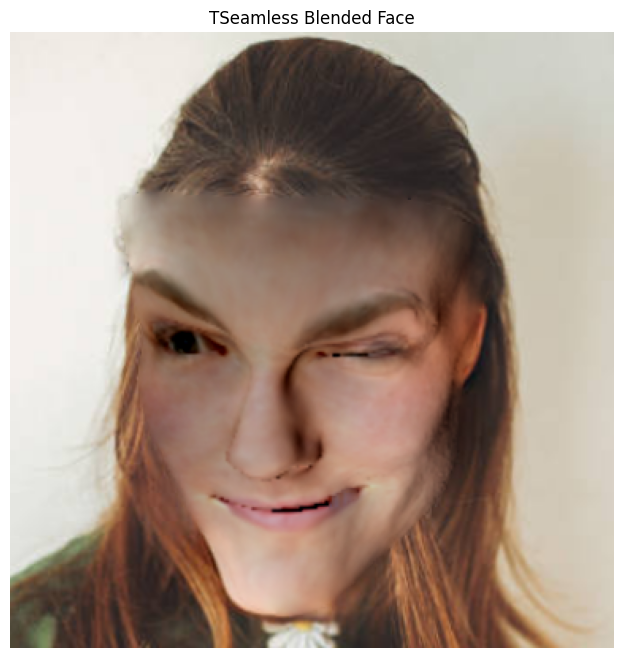

In [9]:
center = (185,233) # Coordinates of the center of the source face in the target image

# Perform Poisson blending using seamlessClone
seamless_blended_image = cv2.seamlessClone(source_image_np, target_image_np, source_mask_np, center, cv2.NORMAL_CLONE)


plt.figure(figsize=(8, 8))

# Plot target image and mask side by side
plt.imshow(seamless_blended_image)
plt.title("TSeamless Blended Face")
plt.axis('off')